# Fertility analysis
In this notebook, we will attempt to examine the fertility rates of women in the census using a varity of methods.

In [3]:
# Load in packages and data
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

from typing import Tuple, List, Dict, Optional

from pathlib import Path

cwd = Path.cwd()

ll_df_cph = pd.read_csv(cwd / 'll_data' / 'll_cph.csv', low_memory=False)
ll_df_aarhus = pd.read_csv(cwd / 'll_data' / 'll_aarhus.csv', low_memory=False)
ll_df_odense = pd.read_csv(cwd / 'll_data' / 'll_odense.csv', low_memory=False)

df_list = [ll_df_cph, ll_df_aarhus, ll_df_odense]
county_names = ['københavn', 'århus', 'odense']

print(ll_df_cph.head())

print(ll_df_cph.columns)

print(ll_df_cph.dtypes)

    pa_id sex marital_status  event_year                            name_cl  \
0  325808   m           gift        1845          peter nielsen svendalhuus   
1  325809   f           gift        1845                      marie nielsen   
2  325810   f          ugift        1845       henriette sophie christensen   
3  271659   f            NaN        1845  hansine charlotte augusta nielsen   
4  271660   m            NaN        1845    carl frederik christian nielsen   

    age event_parish event_county          household_id household_position  \
0  44.0          NaN    københavn  50347_1845_københavn                NaN   
1  43.0          NaN    københavn  50347_1845_københavn               kone   
2  37.0          NaN    københavn  50347_1845_københavn                NaN   
3  10.0          NaN    københavn  50347_1845_københavn               barn   
4   8.0          NaN    københavn  50347_1845_københavn               barn   

   role  
0   NaN  
1   NaN  
2   NaN  
3   NaN  
4   Na

# Naive method

In [2]:
def analyze_fertility(df_list, county_names):
    """
    Analyze fertility patterns of married women using both strict and broad definitions
    """
    # Combine all dataframes
    for df, county in zip(df_list, county_names):
        if 'event_county' not in df.columns:
            df['event_county'] = county
    combined_df = pd.concat(df_list, ignore_index=True)
    
    # Initialize results storage
    results = {
        'county_level': {},
        'parish_level': {},
        'aggregate': {}
    }
    
    # Process each county
    for county in county_names:
        county_data = combined_df[combined_df['event_county'] == county]
        results['county_level'][county] = {}
        results['parish_level'][county] = {}
        
        # Process each year
        for year in sorted(county_data['event_year'].unique()):
            year_data = county_data[county_data['event_year'] == year]
            
            # Get all households with married women
            married_women = year_data[
                (year_data['sex'] == 'f') & 
                (year_data['marital_status'] == 'gift')
            ]
            
            # Initialize parish-level storage for this year
            results['parish_level'][county][year] = {}
            
            # Calculate fertility for each parish
            parish_results = []
            for parish in year_data['event_parish'].unique():
                parish_data = year_data[year_data['event_parish'] == parish]
                parish_married_women = married_women[married_women['event_parish'] == parish]
                
                if len(parish_married_women) > 0:
                    # Calculate both fertility measures for parish
                    strict_children = 0
                    broad_children = 0
                    
                    for _, woman in parish_married_women.iterrows():
                        # Get household members
                        household = parish_data[
                            parish_data['household_id'] == woman['household_id']
                        ]
                        
                        # Strict count (role marked as child)
                        strict_children += len(household[
                            household['household_position'].str.contains('børn|barn|datter|søn',
                                                         case=False, 
                                                         na=False)
                        ])
                        
                        # Broad count (anyone under 15)
                        broad_children += len(household[household['age'] < 15])
                    
                    parish_results.append({
                        'parish': parish,
                        'married_women': len(parish_married_women),
                        'strict_children': strict_children,
                        'broad_children': broad_children,
                        'strict_fertility': strict_children / len(parish_married_women),
                        'broad_fertility': broad_children / len(parish_married_women)
                    })
            
            # Store parish-level results
            if parish_results:
                parish_df = pd.DataFrame(parish_results)
                results['parish_level'][county][year] = parish_df
                
                # Calculate county-level aggregates
                results['county_level'][county][year] = {
                    'married_women': parish_df['married_women'].sum(),
                    'strict_fertility': (parish_df['strict_children'].sum() / 
                                       parish_df['married_women'].sum()),
                    'broad_fertility': (parish_df['broad_children'].sum() / 
                                      parish_df['married_women'].sum())
                }
    
    # Calculate aggregate results for each year
    years = sorted(set(year for county_data in results['county_level'].values() 
                      for year in county_data.keys()))
    
    for year in years:
        total_women = 0
        total_strict_children = 0
        total_broad_children = 0
        
        for county in county_names:
            if year in results['county_level'][county]:
                county_data = results['county_level'][county][year]
                total_women += county_data['married_women']
                total_strict_children += (county_data['strict_fertility'] * 
                                        county_data['married_women'])
                total_broad_children += (county_data['broad_fertility'] * 
                                       county_data['married_women'])
        
        if total_women > 0:
            results['aggregate'][year] = {
                'married_women': total_women,
                'strict_fertility': total_strict_children / total_women,
                'broad_fertility': total_broad_children / total_women
            }
    
    return results

def print_fertility_summary(results):
    """
    Print formatted fertility analysis results
    """
    print("=== FERTILITY ANALYSIS SUMMARY ===\n")
    
    # Print aggregate results
    print("AGGREGATE FERTILITY RATES")
    print("-" * 70)
    print("Year | Married Women | Strict Fertility | Broad Fertility")
    print("-" * 70)
    
    for year in sorted(results['aggregate'].keys()):
        data = results['aggregate'][year]
        print(f"{year} | {data['married_women']:^13d} | "
              f"{data['strict_fertility']:^15.2f} | "
              f"{data['broad_fertility']:^14.2f}")
    
    # Print county-level results
    print("\nCOUNTY-LEVEL FERTILITY RATES")
    for county in results['county_level'].keys():
        print(f"\n{county}")
        print("-" * 70)
        print("Year | Married Women | Strict Fertility | Broad Fertility")
        print("-" * 70)
        
        for year in sorted(results['county_level'][county].keys()):
            data = results['county_level'][county][year]
            print(f"{year} | {data['married_women']:^13d} | "
                  f"{data['strict_fertility']:^15.2f} | "
                  f"{data['broad_fertility']:^14.2f}")
    
    # Print parish-level results
    print("\nPARISH-LEVEL FERTILITY RATES")
    for county in results['parish_level'].keys():
        print(f"\n{county}")
        for year in sorted(results['parish_level'][county].keys()):
            print(f"\nYear: {year}")
            print("-" * 85)
            print("Parish | Married Women | Strict Fertility | Broad Fertility")
            print("-" * 85)
            
            parish_df = results['parish_level'][county][year]
            for _, row in parish_df.iterrows():
                print(f"{row['parish'][:20]:20s} | {row['married_women']:^13d} | "
                      f"{row['strict_fertility']:^15.2f} | "
                      f"{row['broad_fertility']:^14.2f}")

def create_fertility_visualization(results):
    """
    Create visualization comparing fertility rates across counties over time
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # Prepare data for plotting
    counties = list(results['county_level'].keys())
    years = sorted(set(year for county_data in results['county_level'].values() 
                      for year in county_data.keys()))
    
    # Plot strict fertility rates
    for county in counties:
        county_years = sorted(results['county_level'][county].keys())
        strict_rates = [results['county_level'][county][year]['strict_fertility'] 
                       for year in county_years]
        ax1.plot(county_years, strict_rates, marker='o', label=county)
    
    ax1.set_title('Strict Fertility Rates Over Time')
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Children per Married Woman')
    ax1.legend()
    ax1.grid(True)
    
    # Plot broad fertility rates
    for county in counties:
        county_years = sorted(results['county_level'][county].keys())
        broad_rates = [results['county_level'][county][year]['broad_fertility'] 
                      for year in county_years]
        ax2.plot(county_years, broad_rates, marker='o', label=county)
    
    ax2.set_title('Broad Fertility Rates Over Time')
    ax2.set_xlabel('Year')
    ax2.set_ylabel('Children per Married Woman')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    return fig

=== FERTILITY ANALYSIS SUMMARY ===

AGGREGATE FERTILITY RATES
----------------------------------------------------------------------
Year | Married Women | Strict Fertility | Broad Fertility
----------------------------------------------------------------------
1787 |     16677     |      3.08       |      4.30     
1801 |     18728     |      1.78       |      1.68     
1834 |     23145     |      2.53       |      2.32     
1840 |     23664     |      3.62       |      3.14     
1845 |     24445     |      3.06       |      2.71     
1850 |     25177     |      3.10       |      2.77     
1860 |     29977     |      1.94       |      2.00     
1880 |     33614     |      3.13       |      2.94     
1901 |     31567     |      2.00       |      1.72     

COUNTY-LEVEL FERTILITY RATES

københavn
----------------------------------------------------------------------
Year | Married Women | Strict Fertility | Broad Fertility
----------------------------------------------------------------

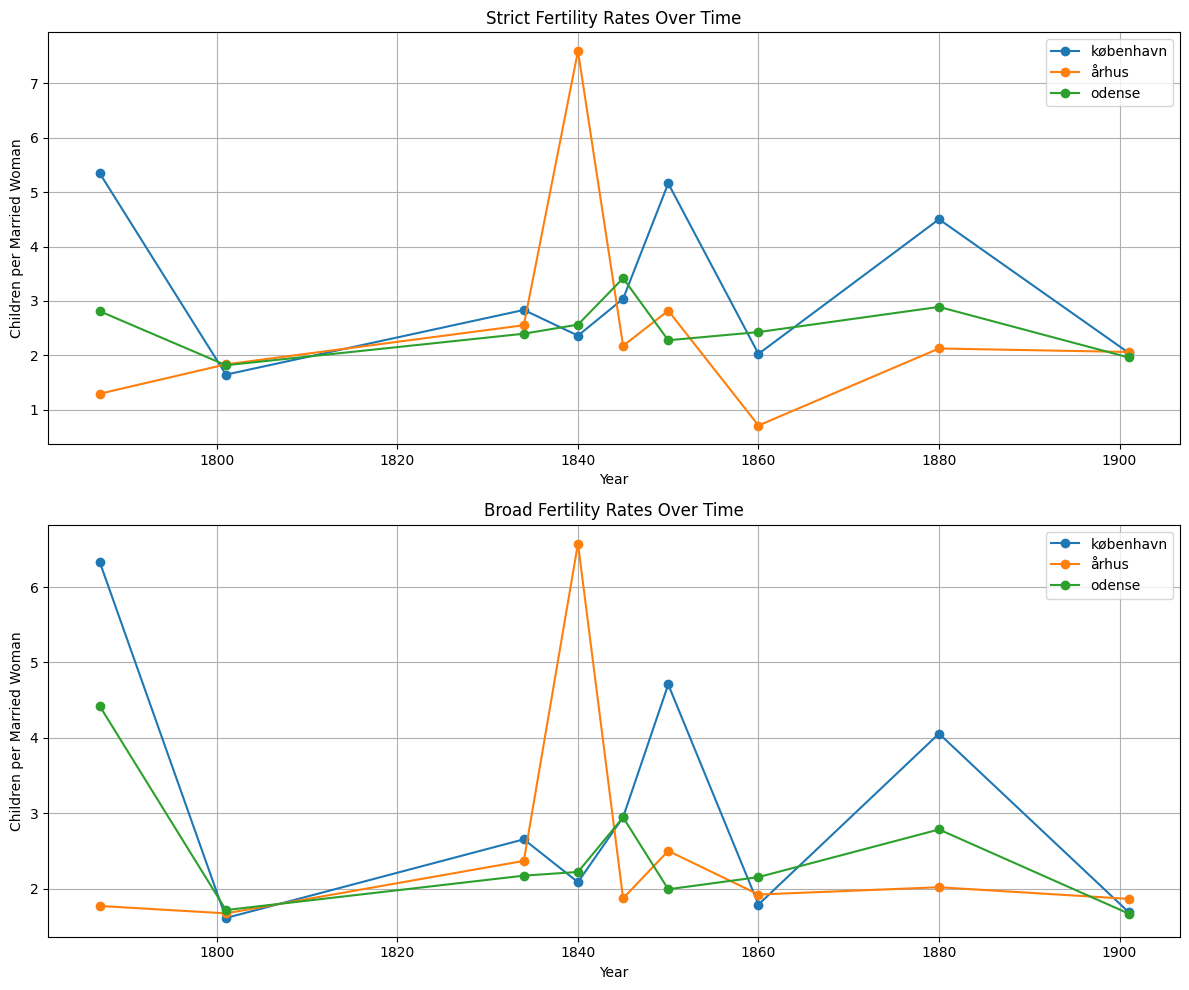

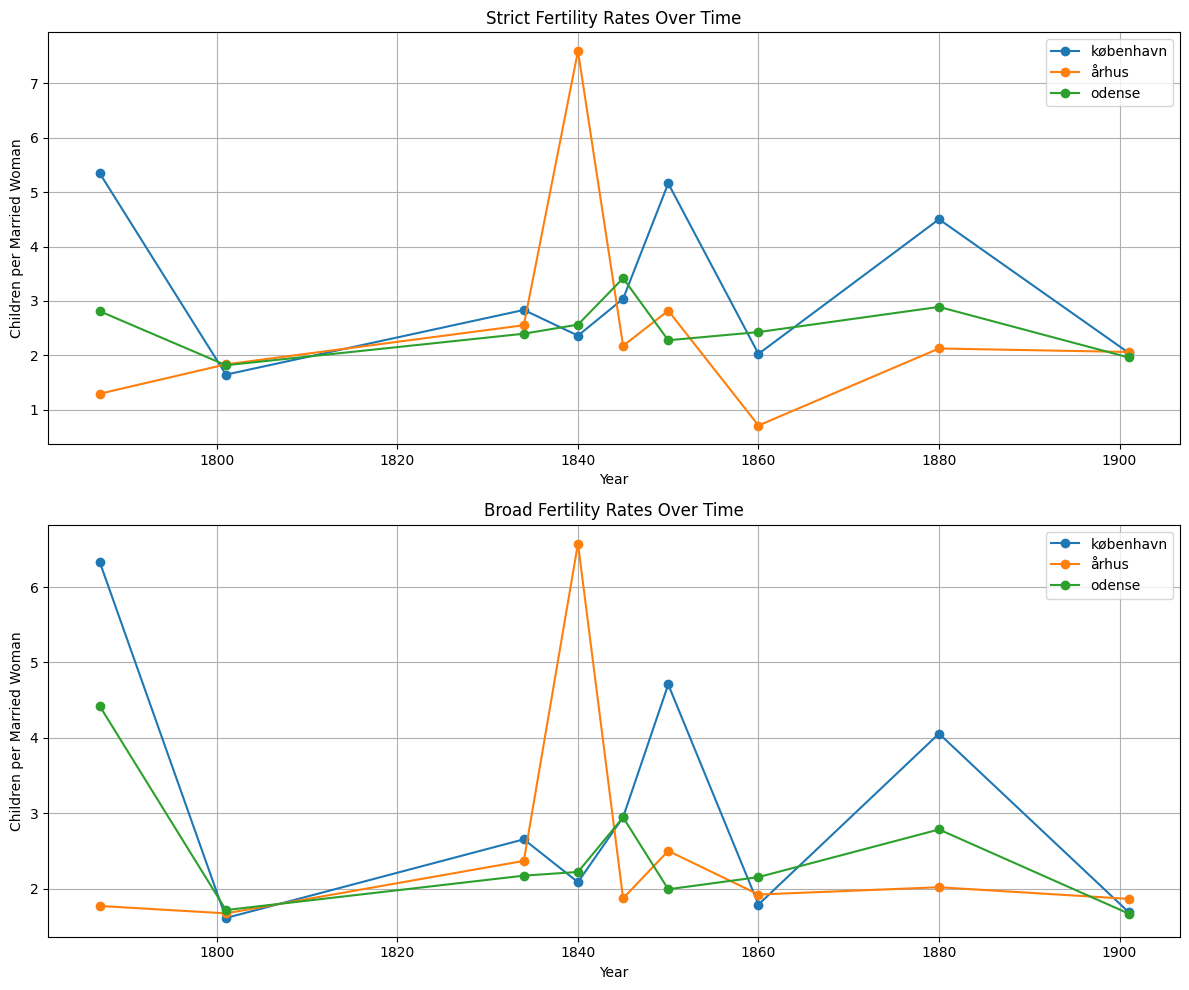

In [3]:
results = analyze_fertility(df_list, county_names)
print_fertility_summary(results)
create_fertility_visualization(results)

# Expanded Methods

In [4]:
from typing import List, Dict, Tuple, Optional, Union
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass

@dataclass
class FertilityResults:
    county: str
    year: int
    cwr: float
    ocm: float
    asfr: Dict[str, float]

def calculate_child_woman_ratio(data: pd.DataFrame) -> float:
    """Optimized CWR calculation"""
    young_children = (data['age'] <= 4).sum()
    women_childbearing = ((data['sex'] == 'f') & 
                         (data['age'] >= 15) & 
                         (data['age'] <= 49)).sum()
    
    return (young_children / women_childbearing * 1000) if women_childbearing > 0 else 0

def calculate_own_children_fertility(data: pd.DataFrame) -> float:
    """Optimized OCM calculation using groupby operations"""
    # Pre-filter for efficiency
    mothers = data[(data['sex'] == 'f') & (data['marital_status'] == 'gift')]
    
    if len(mothers) == 0:
        return 0
    
    # Create a household children count series
    children_mask = (data['household_position'].str.contains('børn|barn|datter|søn|son|born', case=False, na=False))
    household_children = data[children_mask].groupby('household_id').size()
    
    # Match mothers with their household's children count
    mothers_children = mothers['household_id'].map(household_children.get).fillna(0)
    
    return mothers_children.mean()

def calculate_age_specific_fertility(data: pd.DataFrame) -> Dict[str, float]:
    """Optimized ASFR calculation using groupby operations"""
    age_groups: List[Tuple[int, int]] = [(20,24), (25,29), (30,34), (35,39), (40,44)]
    rates: Dict[str, float] = {}
    
    # Pre-calculate household children counts
    children_mask = ((data['age'] < 15) & 
                    (data['household_position'].str.contains('børn|barn|datter|søn|son|born', case=False, na=False)))
    household_children = data[children_mask].groupby('household_id').size()
    
    for min_age, max_age in age_groups:
        # Get women in this age group
        women = data[(data['sex'] == 'f') & 
                    (data['marital_status'] == 'gift') &
                    (data['age'] >= min_age) & 
                    (data['age'] <= max_age)]
        
        if len(women) == 0:
            rates[f"{min_age}-{max_age}"] = 0
            continue
            
        # Match women with their household's children count
        women_children = women['household_id'].map(household_children.get).fillna(0)
        rates[f"{min_age}-{max_age}"] = women_children.mean()
    
    return rates

def analyze_fertility_methods(df_list: List[pd.DataFrame], 
                            county_names: List[str]) -> Dict[str, List[FertilityResults]]:
    """Optimized main analysis function"""
    # Combine dataframes
    for df, county in zip(df_list, county_names):
        if 'event_county' not in df.columns:
            df['event_county'] = county
    combined_df = pd.concat(df_list, ignore_index=True)
    
    results: Dict[str, List[FertilityResults]] = {county: [] for county in county_names}
    
    # Process each county and year
    for county in county_names:
        county_data = combined_df[combined_df['event_county'] == county]
        
        for year in sorted(county_data['event_year'].unique()):
            year_data = county_data[county_data['event_year'] == year]
            
            results[county].append(FertilityResults(
                county=county,
                year=year,
                cwr=calculate_child_woman_ratio(year_data),
                ocm=calculate_own_children_fertility(year_data),
                asfr=calculate_age_specific_fertility(year_data)
            ))
    
    return results

def create_fertility_visualizations(results: Dict[str, List[FertilityResults]]) -> Dict[str, plt.Figure]:
    """
    Create visualizations for all fertility measures, with ASFR using facets
    
    Args:
        results: Dictionary of fertility results by county
    
    Returns:
        Dictionary of matplotlib figures
    """
    figures: Dict[str, plt.Figure] = {}
    
    # Child-Woman Ratio Plot remains the same
    fig_cwr, ax_cwr = plt.subplots(figsize=(12, 6))
    for county, county_results in results.items():
        years = [r.year for r in county_results]
        cwrs = [r.cwr for r in county_results]
        ax_cwr.plot(years, cwrs, marker='o', label=county)
    
    ax_cwr.set_title('Child-Woman Ratio Over Time\n(Children 0-4 per 1000 Women 15-49)')
    ax_cwr.set_xlabel('Year')
    ax_cwr.set_ylabel('Child-Woman Ratio')
    ax_cwr.legend()
    ax_cwr.grid(True)
    figures['cwr'] = fig_cwr
    
    # Own-Children Method Plot remains the same
    fig_ocm, ax_ocm = plt.subplots(figsize=(12, 6))
    for county, county_results in results.items():
        years = [r.year for r in county_results]
        ocms = [r.ocm for r in county_results]
        ax_ocm.plot(years, ocms, marker='o', label=county)
    
    ax_ocm.set_title('Own-Children Method Fertility Estimates Over Time')
    ax_ocm.set_xlabel('Year')
    ax_ocm.set_ylabel('Children per Married Woman')
    ax_ocm.legend()
    ax_ocm.grid(True)
    figures['ocm'] = fig_ocm
    
    # Create new faceted ASFR plot
    # First, prepare the data in a format suitable for faceting
    age_groups = list(next(iter(results.values()))[0].asfr.keys())
    plot_data = []
    
    for county, county_results in results.items():
        for result in county_results:
            for age_group, rate in result.asfr.items():
                plot_data.append({
                    'County': county,
                    'Year': result.year,
                    'Age Group': age_group,
                    'Fertility Rate': rate
                })
    
    df_plot = pd.DataFrame(plot_data)
    
    # Create faceted plot
    n_age_groups = len(age_groups)
    fig_asfr, axes = plt.subplots(n_age_groups, 1, figsize=(12, 3*n_age_groups))
    
    # Ensure axes is always a list, even with one subplot
    if n_age_groups == 1:
        axes = [axes]
    
    # Plot each age group in its own facet
    for ax, age_group in zip(axes, sorted(age_groups)):
        age_group_data = df_plot[df_plot['Age Group'] == age_group]
        
        for county in results.keys():
            county_data = age_group_data[age_group_data['County'] == county]
            ax.plot(county_data['Year'], county_data['Fertility Rate'], 
                   marker='o', label=county)
        
        ax.set_title(f'Age Group: {age_group}')
        ax.set_ylabel('Children per Married Woman')
        ax.grid(True)
        ax.legend()
    
    # Add common xlabel to the bottom
    axes[-1].set_xlabel('Year')
    
    # Add overall title
    fig_asfr.suptitle('Age-Specific Fertility Rates Over Time by Age Group', 
                      y=1.02, fontsize=12)
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    figures['asfr'] = fig_asfr
    
    return figures

def print_fertility_summary_county(results: Dict[str, List[FertilityResults]]) -> None:
    """
    Print summary of fertility analysis results

    Args:
        results: Dictionary of fertility results by county
    """
    print("=== FERTILITY ANALYSIS SUMMARY ===\n")

    for county, county_results in results.items():
        print(f"\n{county.upper()}")
        print("-" * 80)
        print("Year | Child-Woman Ratio | Own-Children Method | ASFR (20-24) | ASFR (30-34) | ASFR (40-44)")
        print("-" * 80)
        
        for result in sorted(county_results, key=lambda x: x.year):
            print(f"{result.year} | "
                    f"{result.cwr:^16.1f} | "
                    f"{result.ocm:^17.2f} | "
                    f"{result.asfr['20-24']:^11.2f} | "
                    f"{result.asfr['30-34']:^11.2f} | "
                    f"{result.asfr['40-44']:^11.2f}")


=== FERTILITY ANALYSIS SUMMARY ===


KØBENHAVN
--------------------------------------------------------------------------------
Year | Child-Woman Ratio | Own-Children Method | ASFR (20-24) | ASFR (30-34) | ASFR (40-44)
--------------------------------------------------------------------------------
1787 |      325.6       |       2.14        |    1.28     |    2.16     |    2.06    
1801 |      342.5       |       1.13        |    0.69     |    1.18     |    1.30    
1834 |      320.1       |       2.54        |    1.89     |    2.62     |    2.59    
1840 |      287.6       |       1.97        |    1.09     |    2.05     |    2.18    
1845 |      289.1       |       2.52        |    1.53     |    2.58     |    2.70    
1850 |      306.0       |       2.30        |    1.36     |    2.03     |    2.39    
1860 |      328.8       |       1.64        |    0.81     |    1.67     |    1.95    
1880 |      328.4       |       2.76        |    1.87     |    2.66     |    2.73    
1901 |     

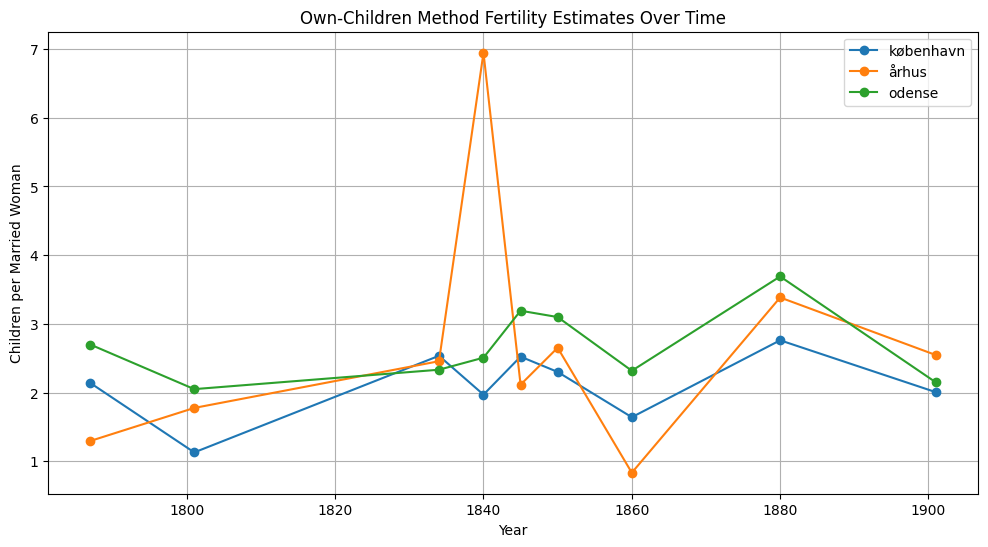

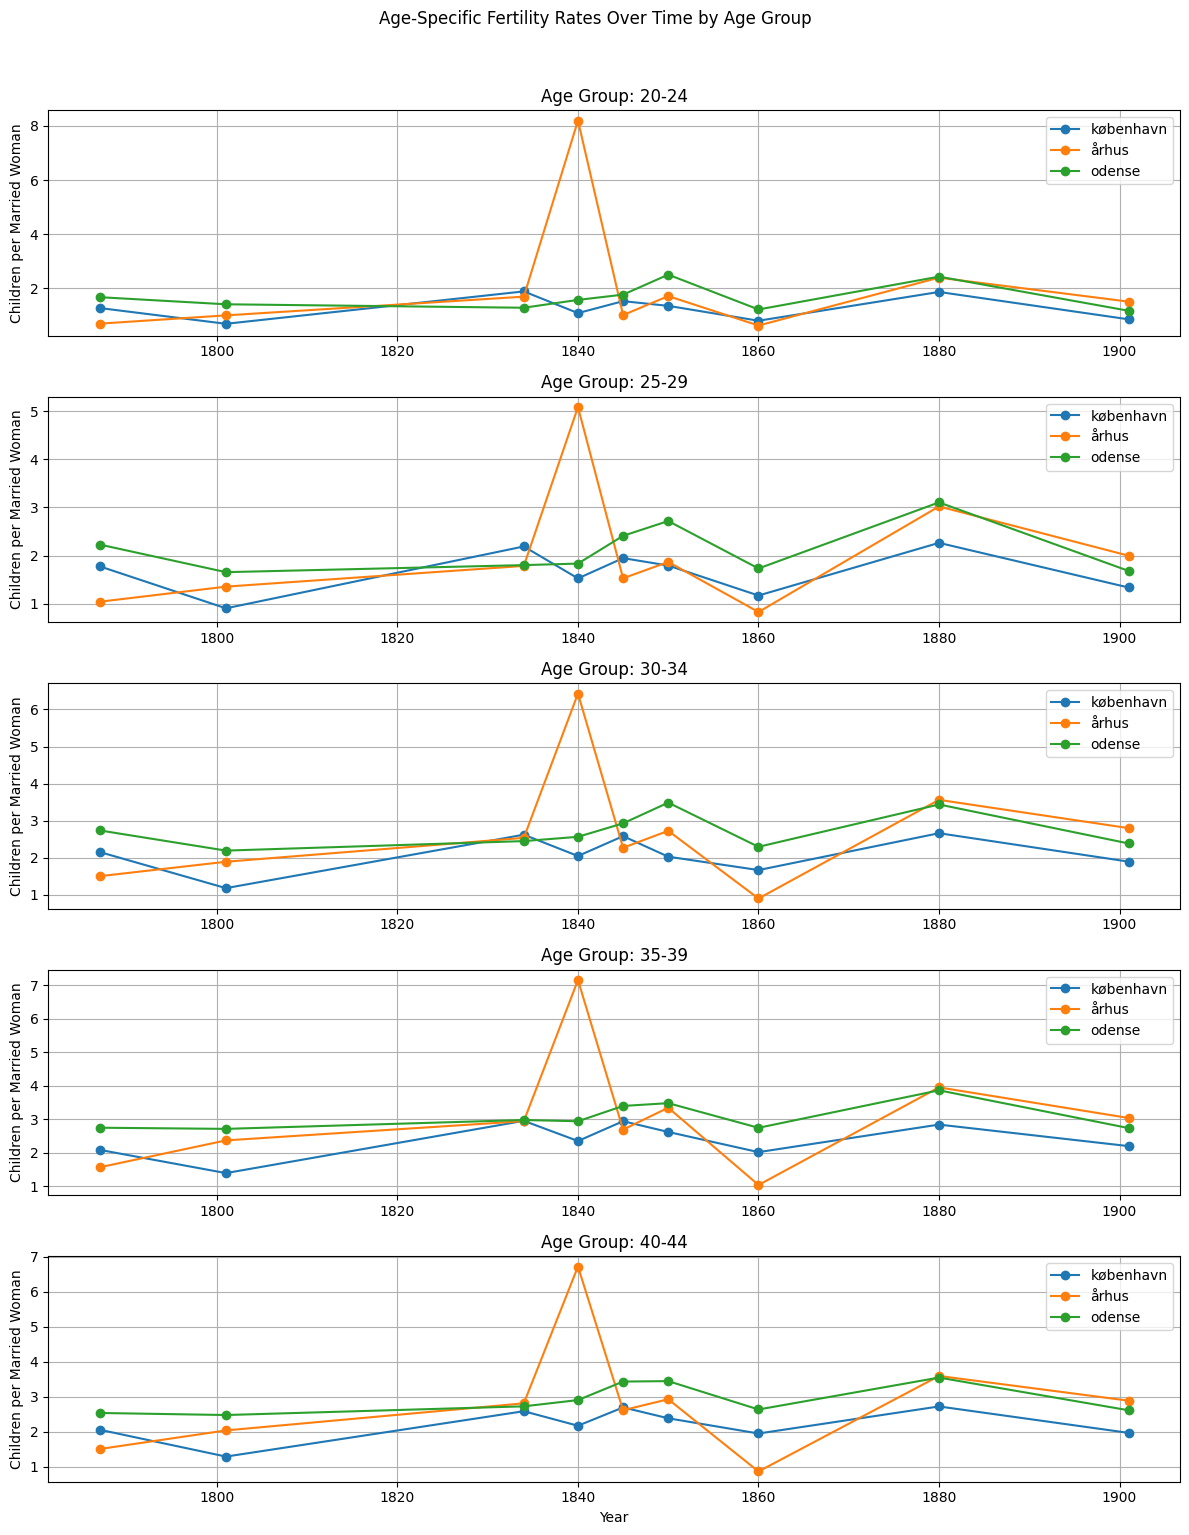

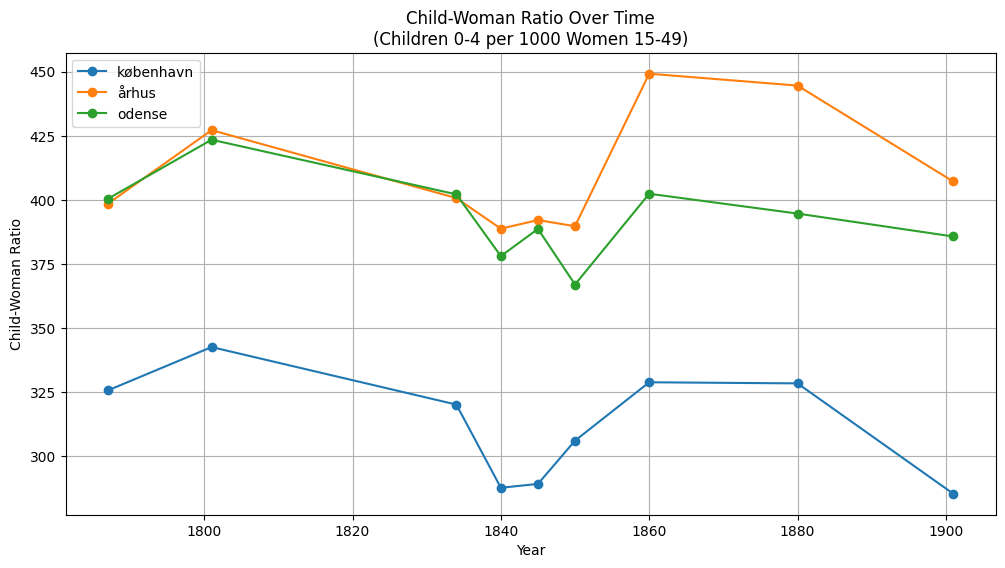

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [5]:
# Run the optimized analysis
fertility_results = analyze_fertility_methods(df_list, county_names)

# Print results and create visualizations as before
print_fertility_summary_county(fertility_results)
figures = create_fertility_visualizations(fertility_results)

for method, fig in figures.items():
    plt.figure(fig.number)
    plt.show()